In [18]:
import librosa
import os
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
def load_audio_dataset(directory):
    audio_data = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if file_path.endswith('.flac'): 
            audio, sr = librosa.load(file_path, sr=None)  
            audio_data.append((audio, sr))
    return audio_data

In [20]:
dataset_directory = 'D:\\audio\\wav48_silence_trimmed\\p225'
audio_dataset = load_audio_dataset(dataset_directory)

In [21]:
audio_dataset

[(array([0.00485229, 0.00689697, 0.00619507, ..., 0.00811768, 0.00836182,
         0.00854492], dtype=float32),
  48000),
 (array([-0.00238037, -0.00350952, -0.0032959 , ..., -0.02999878,
         -0.0289917 , -0.03131104], dtype=float32),
  48000),
 (array([0.00488281, 0.00509644, 0.00543213, ..., 0.00708008, 0.00668335,
         0.0078125 ], dtype=float32),
  48000),
 (array([-1.8310547e-04,  3.0517578e-05, -1.2207031e-04, ...,
         -5.4016113e-03, -5.0964355e-03, -5.6152344e-03], dtype=float32),
  48000),
 (array([0.00338745, 0.00323486, 0.00314331, ..., 0.00131226, 0.00180054,
         0.0017395 ], dtype=float32),
  48000),
 (array([0.00219727, 0.00201416, 0.00210571, ..., 0.00515747, 0.00500488,
         0.00549316], dtype=float32),
  48000),
 (array([ 0.00363159,  0.00506592,  0.00466919, ..., -0.00045776,
          0.00018311,  0.00085449], dtype=float32),
  48000),
 (array([-0.00167847, -0.00238037, -0.00228882, ..., -0.00561523,
         -0.00515747, -0.00561523], dtype=fl

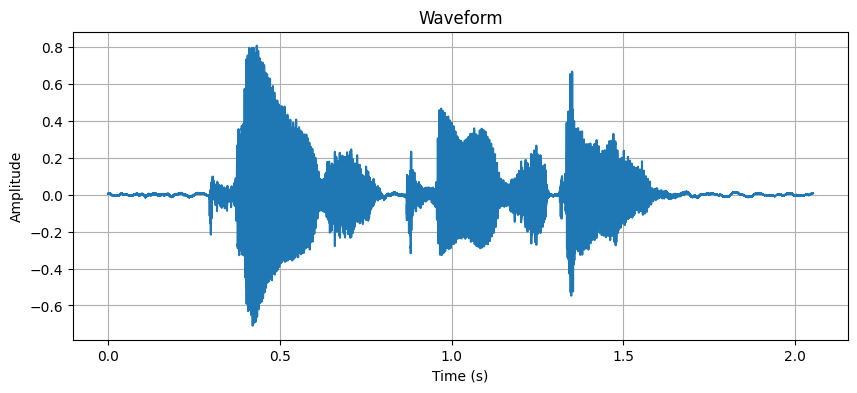

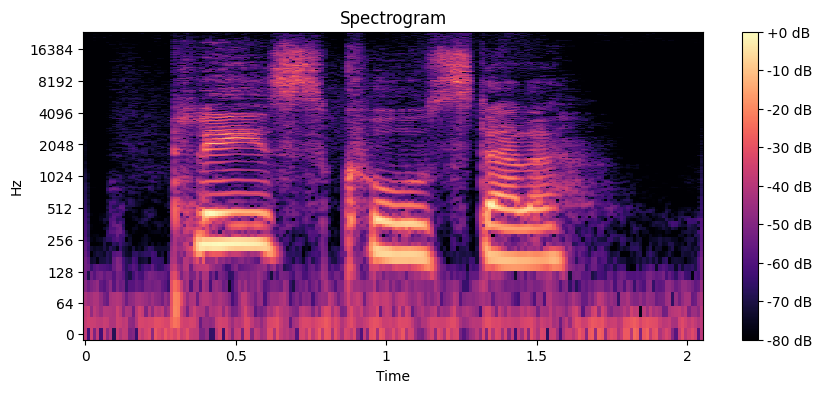

In [22]:
# Get a list of all FLAC files in the directory
flac_files = [file for file in os.listdir(dataset_directory) if file.endswith('.flac')]

if not flac_files:
    print("No FLAC files found in the directory.")
    exit()

# Load the f FLAC file
audio_file_path = os.path.join(dataset_directory, flac_files[0])
audio_data, sampling_rate = librosa.load(audio_file_path, sr=None)

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(audio_data)) / sampling_rate, audio_data)
plt.grid(True)
plt.show()

# Generate and plot the spectrogram
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()


In [23]:


class NuWave(nn.Module):
    def __init__(self):  
        super(NuWave, self).__init__()
        

        self.downsample = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=64, kernel_size=9, stride=2, padding=4),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=9, stride=2, padding=4),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=9, stride=2, padding=4),
            nn.ReLU()
        )
   
        self.middle = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=256, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.Conv1d(in_channels=256, out_channels=256, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.Conv1d(in_channels=256, out_channels=256, kernel_size=9, padding=4),
            nn.ReLU()
        )
        
        # Upsampling layers
        self.upsample = nn.Sequential(
            nn.ConvTranspose1d(in_channels=256, out_channels=128, kernel_size=9, stride=2, padding=4, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=9, stride=2, padding=4, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=64, out_channels=256, kernel_size=9, stride=2, padding=4, output_padding=1)
        )

In [24]:
      
    def forward(self, x):
        
        x = self.downsample(x)
        x = self.middle(x)
        x = self.upsample(x)
        return x

In [25]:
def print_model_summary(model):
    print(model)
    print("\n=== NuWave Model Summary ===\n")
    print("Layer Name               Output Shape")
    print("-------------------------------------")
    
    input_shape = (1, 256, 44000)
    for name, layer in model.named_children():
        output_shape = layer(torch.rand(input_shape)).shape
        print(f"{name:<24} {output_shape}")

In [26]:
model = NuWave()
print_model_summary(model)

NuWave(
  (downsample): Sequential(
    (0): Conv1d(256, 64, kernel_size=(9,), stride=(2,), padding=(4,))
    (1): ReLU()
    (2): Conv1d(64, 128, kernel_size=(9,), stride=(2,), padding=(4,))
    (3): ReLU()
    (4): Conv1d(128, 256, kernel_size=(9,), stride=(2,), padding=(4,))
    (5): ReLU()
  )
  (middle): Sequential(
    (0): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): ReLU()
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (3): ReLU()
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (5): ReLU()
  )
  (upsample): Sequential(
    (0): ConvTranspose1d(256, 128, kernel_size=(9,), stride=(2,), padding=(4,), output_padding=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(128, 64, kernel_size=(9,), stride=(2,), padding=(4,), output_padding=(1,))
    (3): ReLU()
    (4): ConvTranspose1d(64, 256, kernel_size=(9,), stride=(2,), padding=(4,), output_padding=(1,))
  )
)

=== NuWave Model Summary ===

Layer Name      